<a href="https://colab.research.google.com/github/seojihyuk26/EarthquakePredictor/blob/main/earthquakePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 로드

In [242]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [243]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  # raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [244]:
import pandas as pd
from datetime import timedelta

In [245]:
import folium
print("folium version:", folium.__version__)

folium version: 0.12.1.post1


In [246]:
from folium import plugins

In [247]:
from tensorflow.keras.layers import LSTM, Dense, Attention, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses,layers
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
import tensorflow.keras as keras

In [248]:
import matplotlib.pyplot as plt

In [249]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [250]:
from tensorflow.keras.utils import plot_model

In [251]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 초기 변수 설정

In [252]:
timesteps = 3
batch_size = 1
num_epochs = 10
startIndex = 1000
learningIndex = 5000
test_steps = 100
test_start_steps = 12000-learningIndex
test_end_steps = test_start_steps + test_steps

# 데이터 입력

In [253]:
data = pd.read_csv('https://raw.githubusercontent.com/seojihyuk26/EarthquakePredictor/main/earthquake1900.csv')
data

,time,latitude,longitude,depth,mag
0,2022-12-28T16:34:20.446Z,-21.2622,171.3631,10.000,6.00
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910,6.37
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000,6.30
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000,6.30
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346,6.00
...,...,...,...,...,...
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,NaN,6.30
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,NaN,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,NaN,7.10
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,NaN,7.00


In [254]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13823 entries, 0 to 13822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       13823 non-null  object 
 1   latitude   13823 non-null  float64
 2   longitude  13823 non-null  float64
 3   depth      13771 non-null  float64
 4   mag        13823 non-null  float64
dtypes: float64(4), object(1)
memory usage: 540.1+ KB
None
(13823, 5)


# 데이터 전처리

In [255]:
data = data.fillna(data.mean())
data

<ipython-input-255-e8d3a8cf2ef0>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.mean())


,time,latitude,longitude,depth,mag
0,2022-12-28T16:34:20.446Z,-21.2622,171.3631,10.000000,6.00
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910000,6.37
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000000,6.30
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000000,6.30
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346000,6.00
...,...,...,...,...,...
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,56.177293,6.30
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,56.177293,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,56.177293,7.10
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,56.177293,7.00


In [256]:
dataEdited = data.iloc[::-1]
dataEdited

,time,latitude,longitude,depth,mag
13822,1901-03-03T07:45:00.000Z,36.0000,-120.5000,56.177293,6.40
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,56.177293,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,56.177293,7.10
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,56.177293,7.00
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,56.177293,6.30
...,...,...,...,...,...
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346000,6.00
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000000,6.30
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000000,6.30
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910000,6.37


In [257]:
# Convert the time column to datetime
dataEdited['time'] = pd.to_datetime(dataEdited['time'])
dataEdited['original_time'] = dataEdited['time']#pd.Timestamp.to_datetime64()

# Calculate the time difference between each time step
dataEdited['time'] = dataEdited['time'].dt.date.diff().dt.days

dataEdited.loc[dataEdited.shape[0]-1,"time"] = 0

dataEdited

,time,latitude,longitude,depth,mag,original_time
13822,0.0,36.0000,-120.5000,56.177293,6.40,1901-03-03 07:45:00+00:00
13821,302.0,52.0000,-160.0000,56.177293,7.00,1901-12-30 22:34:00+00:00
13820,1.0,51.4500,-171.0200,56.177293,7.10,1901-12-31 09:02:30+00:00
13819,1.0,52.3800,-167.4500,56.177293,7.00,1902-01-01 05:20:30+00:00
13818,320.0,37.4000,-113.5000,56.177293,6.30,1902-11-17 19:50:00+00:00
...,...,...,...,...,...,...
4,7.0,17.2565,-100.4369,18.346000,6.00,2022-12-11 14:31:29.703000+00:00
3,3.0,51.6199,178.6159,73.000000,6.30,2022-12-14 18:40:26.778000+00:00
2,0.0,51.6382,178.6190,73.000000,6.30,2022-12-14 18:40:26.902000+00:00
1,6.0,40.5250,-124.4230,17.910000,6.37,2022-12-20 10:34:24.770000+00:00


In [258]:
class DivideColumns(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1, columns=None):
        self.factor = factor
        self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] / self.factor
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] * self.factor
        return X

In [259]:
class FixedMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, min=0, columns=None):
        self.min = min
        self.columns = columns
        self.length = 1
    
    def fit(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        if X[cols_to_transform].max()[0]-self.min <= 0:
            self.length = 0.0000001
        else:
            self.length = X[cols_to_transform].max()[0]-self.min
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        X[cols_to_transform] = (X[cols_to_transform] - self.min)/self.length
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform]*self.length + self.min
        return X

In [260]:
pipe = ColumnTransformer(transformers=[
    ("time", FixedMinMaxScaler(),["time"]),
    ("latitude", DivideColumns(90),["latitude"]),
    ("longitude", DivideColumns(180),["longitude"]),
    ("depth", FixedMinMaxScaler(),["depth"]),
    ("mag", FixedMinMaxScaler(6),["mag"]),
    ('original_time', 'passthrough',["original_time"])
])
data_scaled = pipe.fit_transform(dataEdited)
data_scaled = pd.DataFrame(data_scaled, index=dataEdited.index, columns=dataEdited.columns)
data_scaled

,time,latitude,longitude,depth,mag,original_time
13822,0.0,0.4,-0.669444,0.081653,0.114286,1901-03-03 07:45:00+00:00
13821,0.94375,0.577778,-0.888889,0.081653,0.285714,1901-12-30 22:34:00+00:00
13820,0.003125,0.571667,-0.950111,0.081653,0.314286,1901-12-31 09:02:30+00:00
13819,0.003125,0.582,-0.930278,0.081653,0.285714,1902-01-01 05:20:30+00:00
13818,1.0,0.415556,-0.630556,0.081653,0.085714,1902-11-17 19:50:00+00:00
...,...,...,...,...,...,...
4,0.021875,0.191739,-0.557983,0.026666,0.0,2022-12-11 14:31:29.703000+00:00
3,0.009375,0.573554,0.992311,0.106105,0.085714,2022-12-14 18:40:26.778000+00:00
2,0.0,0.573758,0.992328,0.106105,0.085714,2022-12-14 18:40:26.902000+00:00
1,0.01875,0.450278,-0.691239,0.026032,0.105714,2022-12-20 10:34:24.770000+00:00


In [261]:
def seq2dataset(seq, window_size):
    dataset = []
    # print(seq.dtypes)
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append(subset)
    # print(dataset.dtype)
    return np.array(dataset)

In [262]:
dataset = seq2dataset(data_scaled.iloc[startIndex:learningIndex,:5], timesteps)
X_train = dataset[:,0:timesteps]
y_train = dataset[:,timesteps]

In [263]:
#X_train[0:3]

In [264]:
#y_train[0:3]

In [265]:
print("input data shape : ", X_train.shape, ", result shape: ", y_train.shape)

input data shape :  (3997, 3, 5) , result shape:  (3997, 5)


In [266]:
dataset_test = seq2dataset(data_scaled[learningIndex:], timesteps)
X_test = dataset_test[:,0:timesteps]
y_test = dataset_test[:,timesteps]
y_test = tf.convert_to_tensor(y_test[:,:5], tf.float32)
# y_test = y_test.numpy()

In [267]:
X_test[0:3]

array([[[0.059375, -0.03671111111111111, 0.818111111111111,
         0.036337209302325583, 0.034285714285714315,
         Timestamp('1958-05-17 07:02:32.250000+0000', tz='UTC')],
        [0.003125, -0.14609999999999998, 0.9265555555555556,
         0.06540697674418605, 0.07428571428571422,
         Timestamp('1958-05-18 02:33:00.190000+0000', tz='UTC')],
        [0.0, -0.14735555555555557, 0.9267055555555554,
         0.06540697674418605, 0.06571428571428584,
         Timestamp('1958-05-18 12:21:24.410000+0000', tz='UTC')]],

       [[0.003125, -0.14609999999999998, 0.9265555555555556,
         0.06540697674418605, 0.07428571428571422,
         Timestamp('1958-05-18 02:33:00.190000+0000', tz='UTC')],
        [0.0, -0.14735555555555557, 0.9267055555555554,
         0.06540697674418605, 0.06571428571428584,
         Timestamp('1958-05-18 12:21:24.410000+0000', tz='UTC')],
        [0.0125, -0.037288888888888885, 0.8137777777777777,
         0.036337209302325583, 0.06857142857142863,
     

In [268]:
y_test[0:3]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.0125    , -0.03728889,  0.8137778 ,  0.03633721,  0.06857143],
       [ 0.009375  , -0.03594444, -0.43265   ,  0.06656977,  0.05428571],
       [ 0.015625  ,  0.5819111 , -0.93730557,  0.05087209,  0.03142857]],
      dtype=float32)>

In [269]:
print("input data shape : ", X_test.shape, ", result shape: ", y_test.shape)

input data shape :  (8820, 3, 6) , result shape:  (8820, 5)


# lstm 모델

In [270]:
# Assume that your input data has shape (batch_size, timesteps, input_dim)
input_dim = 5
output_dim = 5
LSTM_layer = []
with tf.device('/device:GPU:0'):
  inputs = keras.Input(shape=(timesteps, input_dim),batch_size=batch_size) #batch_size
  # inputsDense = Dense(5)(inputs)
  # model = Sequential()
  LSTM_layer.append(LSTM(64,stateful=True)(inputs)) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # LSTM_layer.append(LSTM(64, return_sequences=True, stateful=True)(LSTM_layer[-1])) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # model.add(Attention())
  # model.add(LSTM(64,stateful=True))
  # model.add(Dense(output_dim))
  time = Dense(1,activation='sigmoid', name="time")(LSTM_layer[-1])
  position = Dense(2, name="position")(LSTM_layer[-1])
  depth = Dense(1,activation='sigmoid', name="depth")(LSTM_layer[-1])
  mag = Dense(1, name="mag")(LSTM_layer[-1])
  outputs = concatenate([time, position,depth,mag])

  model = keras.Model(
    inputs=[inputs],
    outputs=[outputs],
)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 3, 5)]          0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (1, 64)              17920       ['input_5[0][0]']                
                                                                                                  
 time (Dense)                   (1, 1)               65          ['lstm_4[0][0]']                 
                                                                                                  
 position (Dense)               (1, 2)               130         ['lstm_4[0][0]']                 
                                                                                            

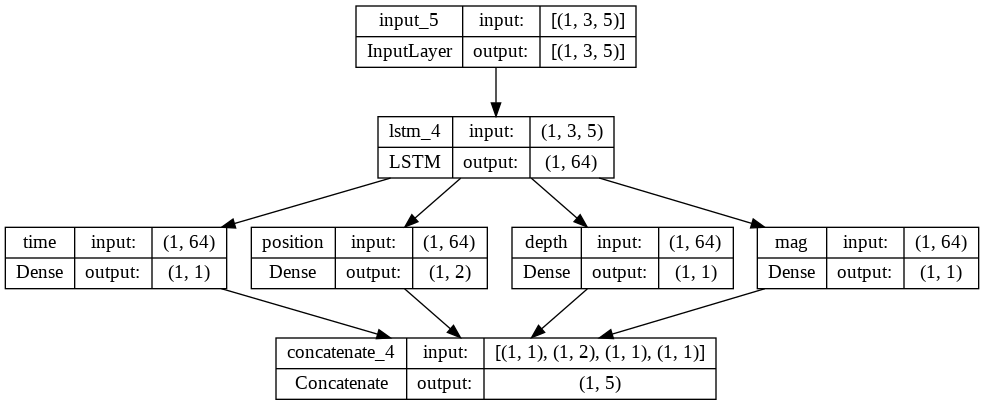

In [271]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [272]:
def degrees_to_radians(deg):
    return np.pi*deg/180

def sphericalToOrthogonal(lat,lon):
  x = tf.math.cos(lat)*tf.math.cos(lon)
  y = tf.math.cos(lat)*tf.math.sin(lon)
  z = tf.math.sin(lat)
  return tf.concat([x,y,z],0)

In [273]:
def haversine_distance_loss(lat1,lon1,lat2,lon2):
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat1 = degrees_to_radians(lat1*90)
    lon1 = degrees_to_radians(lon1*180)
    lat2 = degrees_to_radians(lat2*90)
    lon2 = degrees_to_radians(lon2*180)
    
    p_1 = sphericalToOrthogonal(lat1,lon1)
    p_2 = sphericalToOrthogonal(lat2,lon2)
    
    # 유클리드 거리 공식 사용
    ThreeDimensionalDistance = tf.norm(p_1-p_2)
    
    # 거리의 제곱을 반환
    return (2*tf.math.asin(ThreeDimensionalDistance/2))**2/(np.pi**2)


In [274]:
# haversine_distance_loss(0,1,0.1,0.2)

In [275]:
def custom_loss_function(y_true, y_pred):
    # 위도와 경도는 지구 위의 2개의 점 사이의 거리를 측정하는 커스텀 손실 함수
    distance_loss = haversine_distance_loss(y_true[:, 1], y_true[:, 2], y_pred[:, 1], y_pred[:, 2])
    # 나머지 파라미터는 평균 제곱 오차를 측정하는 함수
    true_time, true_depth, true_mag = y_true[:, 0], y_true[:, 3], y_true[:, 4]
    pred_time, pred_depth, pred_mag = y_pred[:, 0], y_pred[:, 3], y_pred[:, 4]
    
    # Calculate the mean squared error loss for the time, depth, and mag dimensions
    mse_loss = (true_time - pred_time)**2 + (true_depth - pred_depth)**2 + (true_mag - pred_mag)**2

    # mse_loss = losses.mean_squared_error(tf.gather(y_true, [0, 3, 4], axis=1), tf.gather(y_pred, [0, 3, 4], axis=1))
    # 커스텀 손실 함수 결과 반환
    return distance_loss + mse_loss


In [276]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.accuracys = []
        self.term = TerminateOnNaN()
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracys.append(logs.get('acc'))
        self.term.on_epoch_end(batch, logs)

In [277]:
history = LossHistory() # 손실 이력 객체 생성

history.init()

In [278]:
import datetime
log_dir = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [279]:
with tf.device('/device:GPU:0'):
  model.compile(loss=custom_loss_function, optimizer="adam")#tf.keras.optimizers.Adam(learning_rate=0.0001)

# 모델 훈련

In [280]:
#term = TerminateOnNaN()

In [ ]:
with tf.device('/device:GPU:0'):
  
  X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
  y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

  for epoch_idx in range(num_epochs):
      print ('epochs : ' + str(epoch_idx) )
      model.fit(X_train_tensor, y_train_tensor, epochs=1, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history]) #term
      model.reset_states()
    

epochs : 0
3997/3997 - 15s - loss: 0.1860 - 15s/epoch - 4ms/step
epochs : 1
3997/3997 - 12s - loss: 0.1732 - 12s/epoch - 3ms/step
epochs : 2
3997/3997 - 12s - loss: 0.1721 - 12s/epoch - 3ms/step
epochs : 3
3997/3997 - 11s - loss: 0.1714 - 11s/epoch - 3ms/step
epochs : 4
3997/3997 - 11s - loss: 0.1730 - 11s/epoch - 3ms/step
epochs : 5
3997/3997 - 11s - loss: 0.1700 - 11s/epoch - 3ms/step
epochs : 6
3997/3997 - 13s - loss: 0.1693 - 13s/epoch - 3ms/step
epochs : 7
3997/3997 - 12s - loss: 0.1690 - 12s/epoch - 3ms/step
epochs : 8


# 훈련 결과

In [ ]:
#%tensorboard --logdir {log_dir}

In [ ]:
#weights = model.get_weights()
#weights

In [ ]:
# 6. 학습과정 살펴보기
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# 7. 모델 평가하기
X_test_tensor = tf.convert_to_tensor(X_test[:,:,:5], dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
scores = model.evaluate(X_test_tensor, y_test_tensor, batch_size=1)
print("%s: %.2f" %(model.metrics_names[0], scores))
model.reset_states()

# 모델 예상

In [ ]:
X_test_time = X_test[test_start_steps:test_end_steps,:,5]
X_test_time[:3]

In [ ]:
X_test = np.reshape(X_test[test_start_steps:test_end_steps,:,:5],(test_steps,timesteps,5))
X_test[:3]

In [ ]:
y_test = np.reshape(y_test[test_start_steps:test_end_steps,:],(test_steps,5))
y_test = tf.cast(y_test, tf.float32)
y_test[:3]

In [ ]:
y_pred = np.array([])
for i in range(test_steps):
  y_pred = np.append(y_pred,model.predict(tf.convert_to_tensor(X_test[i].reshape(1,timesteps,5), dtype="float32"),verbose=0))
y_pred = tf.reshape(tf.convert_to_tensor(y_pred, dtype=tf.float32),[test_steps,5])
y_pred[:3]

In [ ]:
y_error = []
for i in range(test_steps):
   y_error.append(custom_loss_function(tf.reshape(y_test[i,:],[1,5]),tf.reshape(y_pred[1,:],[1,5])).numpy()[0])
y_error[:3]

# 원래 데이터 포맷으로 돌리기

In [ ]:
def reformTensorToEarthQuake(y_pred,inverse_transform=True):
    y_pred = pd.DataFrame(y_pred.numpy(),index=range(test_steps),columns = data.columns[:5])
    if inverse_transform:
        for column in data.columns[0:5]:
            y_pred.loc[:,[column]] = pipe.named_transformers_[column].inverse_transform(y_pred.loc[:,[column]])
    y_pred["time"] = X_test_time[:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')
    y_pred = y_pred.iloc[::-1]
    y_pred['time'] = y_pred['time'].astype(str)
    return y_pred

In [ ]:
y_test = reformTensorToEarthQuake(y_test)

In [ ]:
y_pred = reformTensorToEarthQuake(y_pred)

In [ ]:
y_pred.info()

In [ ]:
y_test

# 데이터 시각화

In [ ]:
def AddCircles(data,colormap,array):
  surfaceEnergy = np.multiply(10**(data['mag']*1.5),1/(data['depth']**2+1))
  minSurfaceEnergy = surfaceEnergy.min()

  for i, row in data.iterrows():
      borderRadius = np.power(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2,1/6)
      # np.sqrt(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2)
      color = colormap(row['mag'])
      latitude = row['latitude']
      if latitude > 90:
          latitude = 180 - latitude
      elif latitude < -90:
          latitude = - 180 - latitude
      feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [row['longitude'], latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              'icon': 'circle'
          }
      }
      array.append(feature)
      if row['longitude'] < 0 :
        feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [row['longitude']+360, latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              'icon': 'circle'
          }
      }
      array.append(feature)
  return array

In [ ]:
def earthquakeVisualizer(realData,predData):
  

  m = folium.Map(location=[0, 90], zoom_start=2)

  realColormap = folium.LinearColormap(
      ['yellow', 'red','black'],
      vmin=realData['mag'].min(), vmax=realData['mag'].max()
  )
  m.add_child(realColormap)
  predColormap = folium.LinearColormap(
      ['green', 'blue','purple'],
      vmin=predData['mag'].min(), vmax=predData['mag'].max()
  )
  m.add_child(predColormap)

  # 지도 위에 시간 인터렉티브한 바 추가
  timestamps = data['time'].unique()
  features = []
  # minEnergy = 10**(data['mag'].min()*1.5)
  # distanceOfDeepestSixMagReachToOneKM = np.sqrt(data['depth'].max()**2+1)
  features = AddCircles(realData,realColormap,features)
  features = AddCircles(predData,predColormap,features)

  time_slider = plugins.TimestampedGeoJson({
      'type': 'FeatureCollection',
      'features': features
  }, period='P1D',duration="P1M", add_last_point=True, auto_play=False, loop=False)#

  m.add_child(time_slider)

  return m

In [ ]:
m = earthquakeVisualizer(y_test,y_pred)
m.save('EarthQuakePrediction.html')
m

In [ ]:
# earthquakeVisualizer(data)